In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ensure required packages are installed
!pip install torch torchvision geopandas rasterio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 20.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
!pip intall torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import rasterio
import geopandas as gpd
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms

ERROR: unknown command "intall" - maybe you meant "install"


In [ ]:
def get_raster_values(points, raster, bands):
    values = []
    labels = []
    for _, point in points.iterrows():
        row, col = raster.index(point.geometry.x, point.geometry.y)
        band_data = [raster.read(b)[row, col] for b in bands]
        values.append(band_data)
        labels.append(point['class_label'])
    return np.array(values), np.array(labels)

# Read the Sentinel-2 image
image_file = "./drive/MyDrive/Fayoumproject/ProfSafaa/raster/sentinel_mask.img"
sentinel_img = rasterio.open(image_file)

# Prepare training dataset
trainShapefiles = [
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/train/background.shp", 0),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/train/land.shp", 1),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/train/clover.shp", 2),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/train/wheat.shp", 3),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/train/water.shp", 4),
    # ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/train/suger beat.shp", 5),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/train/urban.shp", 6),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/train/trees.shp", 7),
]

train_values = []
train_labels = []

for shapefile_path, class_label in trainShapefiles:
    data = gpd.read_file(shapefile_path)
    data['class_label'] = class_label
    data = data.to_crs(sentinel_img.crs)
    values, labels = get_raster_values(data, sentinel_img, range(1, 11))
    train_values.append(values)
    train_labels.append(labels)

train_values = np.concatenate(train_values)
train_labels = np.concatenate(train_labels)
testShapefiles = [
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/test/background.shp", 0),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/test/land.shp", 1),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/test/clover.shp", 2),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/test/wheat.shp", 3),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/test/water.shp", 4),
    # ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/test/suger beat.shp", 5),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/test/urban.shp", 6),
    ("./drive/MyDrive/Fayoumproject/ProfSafaa/vector/test/trees.shp", 7),
]

test_values = []
test_labels = []

for shapefile_path, class_label in testShapefiles:
    data = gpd.read_file(shapefile_path)
    data['class_label'] = class_label
    data = data.to_crs(sentinel_img.crs)
    values, labels = get_raster_values(data, sentinel_img, range(1, 11))
    test_values.append(values)
    test_labels.append(labels)


test_values = np.concatenate(test_values)
test_labels =np.concatenate(test_labels)

In [ ]:
# Importing necessary libraries


# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / len(labels)

# Function to sample raster values at the points in a shapefile


# Create PyTorch dataset and DataLoader for training
# Create PyTorch dataset and DataLoader for training
class SentinelDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.astype(np.float32), dtype=torch.float32)
        self.labels = torch.tensor(labels.astype(np.int64), dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = SentinelDataset(train_values, train_labels)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)


# Define a simple ResNet model with basic residual blocks
class EnhancedResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 64)
        self.residual_block = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout with 20% rate
            nn.Linear(64, 64)
        )
        self.fc2 = nn.Linear(64, 8)

    def forward(self, x):
        x = self.fc1(x)
        residual = x
        x = self.residual_block(x)
        x += residual  # Residual connection
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Model, loss function, and optimizer
model = EnhancedResNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)  # AdamW optimizer

num_epochs = 100


# Ensure a proper batch size (greater than 1)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop with the updated data loader
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for inputs, targets in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_accuracy += calculate_accuracy(outputs, targets)

    avg_loss = epoch_loss / len(train_loader)
    avg_accuracy = epoch_accuracy / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")



# Create test dataset and DataLoader
test_dataset = SentinelDataset(test_values, test_labels)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Evaluate the model
model.eval()  # Set the model to evaluation mode
test_accuracy = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_accuracy += calculate_accuracy(outputs, targets)

avg_test_accuracy = test_accuracy / len(test_loader)
print(f"Test Accuracy: {avg_test_accuracy:.4f}")


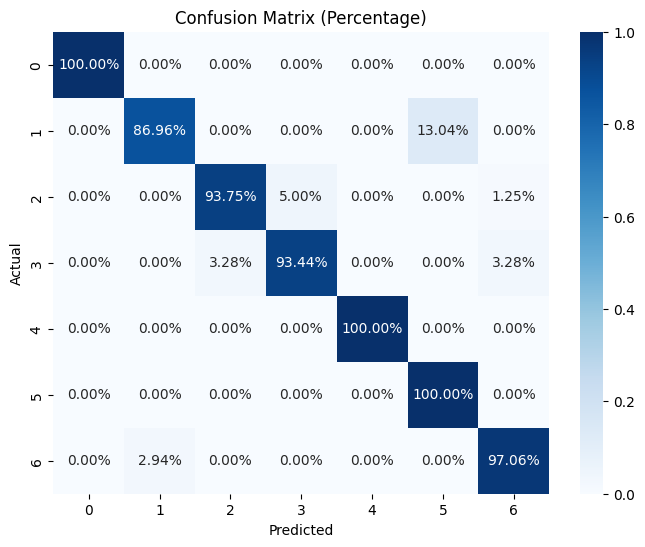

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
import h5py


# Create lists to store predictions and true labels
all_predictions = []
all_targets = []

# Accumulate predictions and true labels from the test DataLoader
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions = outputs.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Normalize the confusion matrix to show percentages
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2%", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Percentage)")

# Save the confusion matrix plot to a file
confusion_matrix_file_path = "confusion_matrix.png"  # You can change this to your preferred file path

# Save the plot
plt.savefig(confusion_matrix_file_path)

# Optionally, show the plot
plt.show()

# Save the model to a file
torch.save(model, "./fullelfull.pth")




In [ ]:
#Save h5 model
import h5py
with h5py.File('model_weights.h5', 'w') as h5f:
    for k, v in model.state_dict().items():
        # Save each parameter in the state dict as a dataset
        h5f.create_dataset(k, data=v.cpu().numpy())


In [ ]:
# Load the entire raster file
raster_data = sentinel_img.read([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Read all bands
raster_height, raster_width = raster_data.shape[1:3]  # Get the shape of the raster

# Prepare the raster data for prediction
raster_flattened = raster_data.reshape(10, -1).T  # Flatten the raster data

# Classify the raster
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    inputs = torch.tensor(raster_flattened.astype(np.float32), dtype=torch.float32)
    outputs = model(inputs)
    _, predicted_classes = torch.max(outputs, 1)  # Get the class index with maximum value
    predictions = predicted_classes.numpy()

# Reshape the predictions to the original raster shape
classified_raster = predictions.reshape(raster_height, raster_width)

# Create a color map for each class
color_map = {
    0: (0, 0, 0),  # Background (black)
    1: (255, 0, 0),  # Land (red)
    2: (0, 255, 0),  # Clover (green)
    3: (0, 0, 255),  # Wheat (blue)
    4: (255, 255, 0),  # Water (yellow)
    5: (255, 0, 255),  # Sugar beet (magenta)
    6: (0, 255, 255),  # Urban (cyan)
    7: (255, 165, 0),  # Trees (orange)
}

# Create a colored raster based on the class color map
colored_raster = np.zeros((raster_height, raster_width, 3), dtype=np.uint8)

for class_value, color in color_map.items():
    mask = (classified_raster == class_value)
    colored_raster[mask] = color

# Output the classified raster with color
output_file = "./classified_raster.tif"  # Define the output file path

# Create a new raster to save the classified data
with rasterio.open(
    output_file,
    'w',
    driver='GTiff',
    height=raster_height,
    width=raster_width,
    count=3,  # Number of color channels (RGB)
    dtype='uint8',
    crs=sentinel_img.crs,
    transform=sentinel_img.transform,
) as dst:
    dst.write(colored_raster[:, :, 0], 1)  # Red channel
    dst.write(colored_raster[:, :, 1], 2)  # Green channel
    dst.write(colored_raster[:, :, 2], 3)  # Blue channel


In [ ]:
# Function to preprocess new data (assuming you have a function like this defined)
import h5py

def preprocess_sentinel_image(image_path, bands_to_use):
    # Open the raster file
    with rasterio.open(image_path) as sentinel_img:
        # Check the number of bands in the image
        num_bands = sentinel_img.count
        print(f"The image has {num_bands} bands.")

        # Ensure you're not trying to read a band that doesn't exist
        bands_to_use = [b for b in bands_to_use if b <= num_bands]

        # Read the specified bands
        img_data = np.stack([sentinel_img.read(band) for band in bands_to_use])

    return img_data


# Function to post-process the output
def post_process_output(output):
    # Apply softmax to convert logits to probabilities
    probabilities = torch.softmax(output, dim=1)
    # Get the predicted class labels
    _, predicted_labels = torch.max(probabilities, 1)
    return predicted_labels


# Assume 'new_image_path' is the path to your new Sentinel-2 image
def predict_image_class(image_path, model):
    # Preprocess the image
    img_data = preprocess_sentinel_image(image_path, bands_to_use)

    # Check if image data has the correct shape (10 bands)
    if img_data.shape[0] != len(bands_to_use):
        raise ValueError(f"Expected {len(bands_to_use)} bands, got {img_data.shape[0]}")

    # Flatten the image data to have one pixel per row
    # Reshape from (bands, height, width) to (height * width, bands)
    img_data_flattened = img_data.transpose((1, 2, 0)).reshape(-1, len(bands_to_use))

    # Convert to PyTorch tensor and add batch dimension if necessary
    img_tensor = torch.tensor(img_data_flattened, dtype=torch.float32)

    # Set the model to evaluation mode
    model.eval()

    # Initialize a list to store the predictions
    predictions = []

    # If the data is too large to process in one go, you may need to process it in batches
    batch_size = 256  # Batch size can be tuned based on your system's memory capacity
    for i in range(0, img_tensor.size(0), batch_size):
        batch = img_tensor[i:i + batch_size]
        with torch.no_grad():
            outputs = model(batch)
        _, batch_predictions = torch.max(outputs, 1)
        predictions.append(batch_predictions)

    # Concatenate all batch predictions
    predictions = torch.cat(predictions)

    # Reshape predictions to the original image dimensions
    predicted_labels = predictions.reshape(img_data.shape[1], img_data.shape[2])
    predicted_labels_flat = predicted_labels.flatten()
    class_counts = np.bincount(predicted_labels_flat)
    most_frequent_class = np.argmax(class_counts)
    most_frequent_count = class_counts[most_frequent_class]

    # Calculate the percentage of the image that is the most frequent class
    most_frequent_percentage = (most_frequent_count / predicted_labels_flat.size()) * 100

    # Print the most frequent class and its percentage
    print(f"Most frequent class: {most_frequent_class}")
    print(f"Percentage of image: {most_frequent_percentage}%")

    # Return the predicted labels and the most frequent class info
    return predicted_labels, most_frequent_class, most_frequent_percentage



# Example usage:
# Make sure to replace "path_to_your_model.pth" with your actual model file path,
# and "path_to_new_sentinel_image.tif" with the actual path to the new Sentinel-2 image.

new_image_path = "./drive/MyDrive/last-test.tif"
bands_to_use = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Assuming 'model' is your trained PyTorch model
torch.save(model.state_dict(), 'model_weights.pth')


with h5py.File('model_weights.h5', 'w') as h5f:
    for k, v in model.state_dict().items():
        # Save each parameter in the state dict as a dataset
        h5f.create_dataset(k, data=v.cpu().numpy())




# Predict the class for the new image
predicted_labels, most_frequent_class, most_frequent_percentage = predict_image_class(new_image_path, model)
print("Predicted Class Labels:\n", predicted_labels)
print("Predicted Class Labels:", predicted_labels.numpy())
print("final class " , most_frequent_class, "   ", most_frequent_percentage)




The image has 10 bands.
Most frequent class: 1
Percentage of image: [100.]%
Predicted Class Labels:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Predicted Class Labels: [[1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]]
final class  1     [100.]
